In [1]:
import scanpy as sc 
import pandas as pd
import SEACells
import numpy as np
import matplotlib
from statistics import mode
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

data_path = "/ibex/user/alsulara/Cell-Type-Specific-Graphs/Data/"
save_path_results = "/ibex/user/alsulara/Cell-Type-Specific-Graphs/Results/"


2025-02-22 12:56:05.132748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-02-22 12:56:09.331867: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
adata = sc.read(data_path+"ChangYe2021.h5ad")
adata.obs['cell_line'] = 'PC9'
print(adata)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata = adata[:, adata.var[(adata.var.mt == False) & (adata.var.ribo == False)].index.values]
adata

AnnData object with n_obs × n_vars = 42277 × 45066
    obs: 'sample', 'disease', 'cancer', 'sex', 'perturbation', 'dose_value', 'dose_unit', 'perturbation_type', 'organism', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line'
    var: 'ensembl_gene_id', 'ncounts', 'ncells'


View of AnnData object with n_obs × n_vars = 42277 × 43977
    obs: 'sample', 'disease', 'cancer', 'sex', 'perturbation', 'dose_value', 'dose_unit', 'perturbation_type', 'organism', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_line'
    var: 'ensembl_gene_id', 'ncounts', 'ncells', 'mt', 'ribo'

In [3]:
adata.obs.rename({"cell_line": "cell_type"}, axis=1, inplace=True)
adata.obs.rename({"perturbation": "condition"}, axis=1, inplace=True)

In [4]:
print(adata.obs.condition.value_counts())
print(adata.obs.dose_value.value_counts())
print(adata.obs.cell_type.value_counts())

condition
control      21043
GNE-104       8737
erlotinib     6577
GNE-069       5920
Name: count, dtype: int64
dose_value
1    21234
0    21043
Name: count, dtype: int64
cell_type
PC9    42277
Name: count, dtype: int64


<Axes: xlabel='ncounts', ylabel='ngenes'>

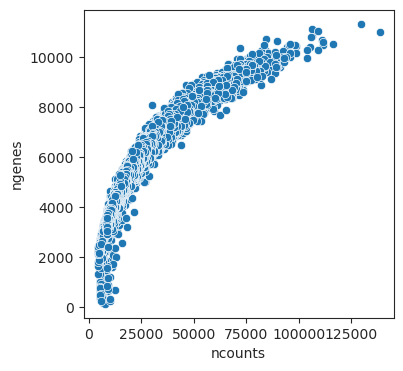

In [5]:
sns.scatterplot(data=adata.obs, x="ncounts", y="ngenes")

In [6]:
# basic qc and pp
print(adata)
adata.layers['counts'] = adata.X.copy()

# remove cells that have less than 1000 counts
sc.pp.filter_cells(adata, min_counts=1000, inplace =True)

# remove genes that are detected in less than 20 cells
sc.pp.filter_genes(adata, min_cells=50, inplace =True)
adata

View of AnnData object with n_obs × n_vars = 42277 × 43977
    obs: 'sample', 'disease', 'cancer', 'sex', 'condition', 'dose_value', 'dose_unit', 'perturbation_type', 'organism', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_type'
    var: 'ensembl_gene_id', 'ncounts', 'ncells', 'mt', 'ribo'


AnnData object with n_obs × n_vars = 42236 × 26070
    obs: 'sample', 'disease', 'cancer', 'sex', 'condition', 'dose_value', 'dose_unit', 'perturbation_type', 'organism', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_type', 'n_counts'
    var: 'ensembl_gene_id', 'ncounts', 'ncells', 'mt', 'ribo', 'n_cells'
    layers: 'counts'

In [7]:
# log-normalize the counts
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes = 5000)
adata

AnnData object with n_obs × n_vars = 42236 × 5000
    obs: 'sample', 'disease', 'cancer', 'sex', 'condition', 'dose_value', 'dose_unit', 'perturbation_type', 'organism', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_type', 'n_counts'
    var: 'ensembl_gene_id', 'ncounts', 'ncells', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [8]:
adata.obs['drug_dose_name'] = adata.obs.condition.astype(str) + '_' + adata.obs.dose_value.astype(str)
adata.obs['cov_drug_dose_name'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.drug_dose_name.astype(str)
adata.obs['cov_drug'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)
label_encoder = preprocessing.LabelEncoder()
adata.obs["condition_label"] = label_encoder.fit_transform(adata.obs["condition"])
num_perts = adata.obs["condition_label"].values.max()+1
print(num_perts)

4


In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

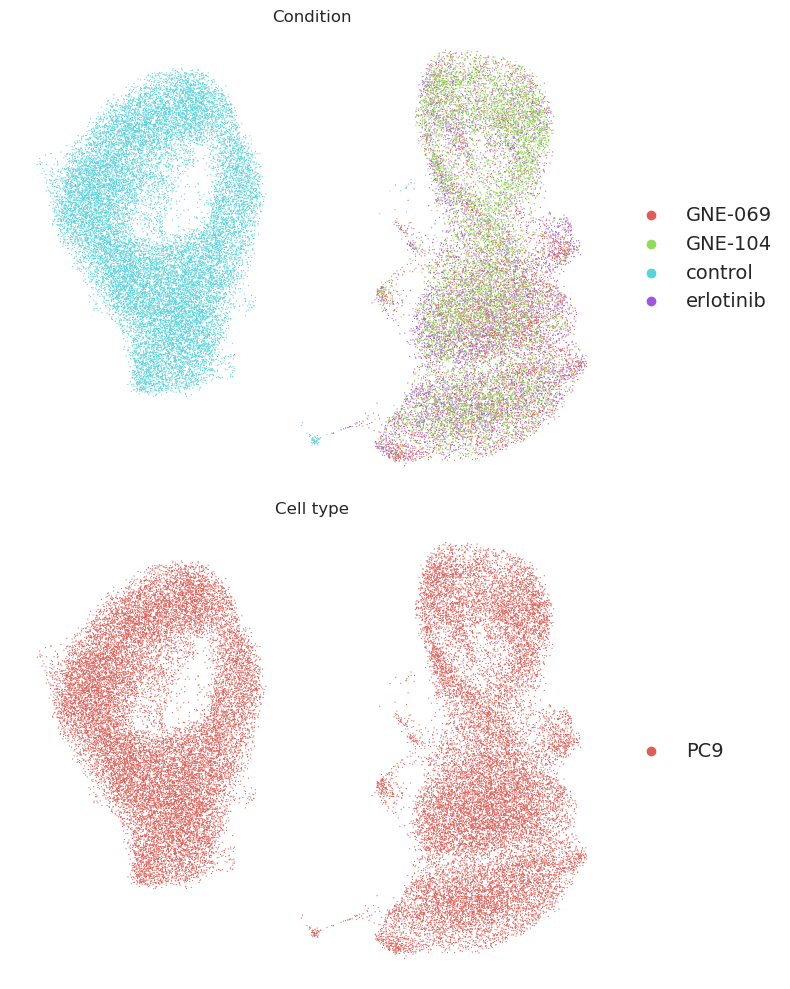

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))  # Adjust figsize as needed
# Plot UMAP 1 in the first subplot if it's not empty
sc.pl.umap(adata=adata, color=["condition"],legend_fontsize=14,ax = axes[0],
           title = "Condition",
           show=False, palette = sns.color_palette("hls", 4),
           frameon=False)

sc.pl.umap(adata=adata, color=["cell_type"],legend_fontsize=14,ax = axes[1],
           title = "Cell type",
           show=False, palette = sns.color_palette("hls", 7),
           frameon=False)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(save_path_results+"Chang_UMAP.pdf")
# Show the merged plot
plt.show()

In [11]:
ctrl_data = adata[adata.obs.condition == 'control'].copy()
ctrl_data

AnnData object with n_obs × n_vars = 21006 × 5000
    obs: 'sample', 'disease', 'cancer', 'sex', 'condition', 'dose_value', 'dose_unit', 'perturbation_type', 'organism', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'chembl-ID', 'cell_type', 'n_counts', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'condition_label'
    var: 'ensembl_gene_id', 'ncounts', 'ncells', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [12]:
n_SEACells = int(len(ctrl_data) / 75)
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [13]:
model = SEACells.core.SEACells(ctrl_data, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [14]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/21006 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/21006 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/21006 [00:00<?, ?it/s]

Constructing CSR matrix...


In [15]:
model.fit(min_iter=10, max_iter=50)

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 274 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 23.23it/s]


Selecting 6 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00269
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 29 iterations.


In [16]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 30 iterations
Ran for 35 iterations


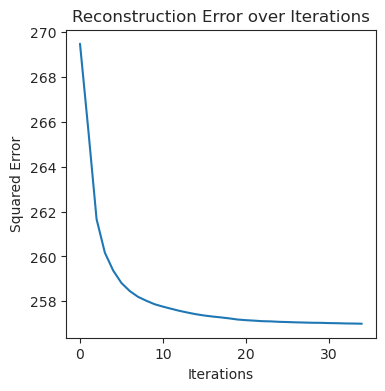

In [17]:
model.plot_convergence()

In [18]:
ctrl_data.obs[['SEACell']].head()
ctrl_data.obs.cell_type

index
GACACGCCAAGGCAACSAMb6ba60b525    PC9
AGGAATACATACCAGTSAMb6ba60b525    PC9
CCTCAGTCACGTAACTSAMb6ba60b525    PC9
TCGGGTGGTAACAGGCSAMb6ba60b525    PC9
CTGATCCTCCGAAATCSAMb6ba60b525    PC9
                                ... 
CGGTCAGTCGCTATTTSAMb6ba60b525    PC9
TCGTAGAGTGGTTCTASAMb6ba60b525    PC9
GCCAACGCACGCTGCASAMb6ba60b525    PC9
GACCAATGTTGGGTTTSAMb6ba60b525    PC9
GATTGGTCACTTCTCGSAMb6ba60b525    PC9
Name: cell_type, Length: 21006, dtype: category
Categories (1, object): ['PC9']

In [19]:
adata.obs['SEACell'] = 'None'
adata.obs.loc[ctrl_data.obs.index.tolist(), 'SEACell'] = ctrl_data.obs['SEACell'].values
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ctrl_data,  model.A_, 
                                                          celltype_label='cell_type', summarize_layer = 'counts', minimum_weight = 0.05)
SEACell_soft_ad.X.A

100%|██████████| 280/280 [04:13<00:00,  1.11it/s]


array([[0.55195189, 0.35096768, 0.55954103, ..., 0.09282054, 0.        ,
        0.        ],
       [1.18971226, 0.4686841 , 1.25540878, ..., 0.0571904 , 0.        ,
        0.        ],
       [0.60350642, 0.35206471, 0.8948563 , ..., 0.10693911, 0.        ,
        0.        ],
       ...,
       [0.61832544, 0.27473964, 0.25844961, ..., 0.06688585, 0.        ,
        0.        ],
       [1.19969481, 0.99578197, 1.10560482, ..., 0.06498245, 0.        ,
        0.        ],
       [1.48691754, 0.60194315, 0.6234425 , ..., 0.14054678, 0.        ,
        0.        ]])

In [20]:
SEACell_soft_ad.obs
SEACell_soft_ad.obs.rename({"celltype": "cell_type"}, axis=1, inplace=True)

In [21]:
SEACell_soft_ad.write(data_path+'SEACell_soft_ad_Chang.h5ad')
adata.write(data_path+'Chang.h5ad')

In [22]:
SEACell_soft_ad = sc.read(data_path+'SEACell_soft_ad_Chang.h5ad')
SEACell_soft_ad
SEACell_soft_ad.var = SEACell_soft_ad.var.reset_index()
SEACell_soft_ad.var.rename({"index": "gene_name"}, axis=1, inplace=True)
SEACell_soft_ad.var.set_index("gene_name", inplace = True)
SEACell_soft_ad

AnnData object with n_obs × n_vars = 280 × 5000
    obs: 'Pseudo-sizes', 'cell_type', 'celltype_purity'

In [23]:
import os
import networkx as nx
from torch_geometric.utils.convert import from_networkx
from sklearn.metrics import mean_squared_error
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip, HeteroData, Batch
from torch_geometric.utils import *
import torch
from torch import nn
cell_type_network = {}
# Leaf directory 
directory = "Chang"
# Parent Directories 
parent_dir = "/ibex/user/alsulara/Cell-Type-Specific-Graphs/graphs/"
# Path 
path = os.path.join(parent_dir, directory)
print(path)
try: 
    os.makedirs(path) 
except:
    print("File exists!")
max_nodes = 0
genes_pos = []
for cell_type in SEACell_soft_ad.obs.cell_type.unique():
    print(cell_type)
    cell = Correlation_matrix(SEACell_soft_ad, cell_type, 'cell_type',
                       hv_genes_cells = None, union_HVGs = True)
    threshold = np.percentile(np.abs(cell[0].values), 99.0)
    print("threshold:", threshold)
    
    g = create_coexpression_graph(SEACell_soft_ad, cell, cell_type, threshold, 'gene_name')
    if g.num_nodes >= max_nodes:
        max_nodes = g.num_nodes
    cell_type_network[cell_type] = g
    genes_pos.append(cell_type_network[cell_type].pos)
    cell_type_network[cell_type].pos = torch.tensor(cell_type_network[cell_type].pos)
    torch.save(cell_type_network[cell_type] , os.path.join(path,cell_type+'_coexpr_graph.pkl'))

cell_type_network    

/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/graphs/Chang
PC9


/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


threshold: 0.7342746402184278
number_of_edges before the threshold (5000 x 5000):  25000000
number_of_edges after the threshold:  250000
number_of_edges after removing self loops:  245002
final number_of_edges:  245002


{'PC9': Data(x=[2049, 280], edge_index=[2, 245002], edge_attr=[245002], pos=[2049])}